In [7]:
import numpy as np
#from googletrans import Translator
from translate import Translator
import wikipedia as wiki
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from nltk.stem.snowball import SnowballStemmer
import nltk
import zipfile
import gensim
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import sys
import os
import wget
import re
from ufal.udpipe import Model, Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.metrics import roc_auc_score, pairwise_distances
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed
import multiprocessing
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from transformers import BertModel

In [8]:
def get_russian_translation(sent):
    """
    Return english translation.

    sent - sentence in russian
    """
    translator = Translator(to_lang="ru", from_lang='eng')
    return  translator.translate(sent)

def get_english_translation(sent):
    """
    Return english translation.

    sent - sentence in russian
    """
    translator = Translator(to_lang="eng", from_lang='ru')
    return  translator.translate(sent)


def get_wiki_titles(sent, count):
    """
    Return titles of wikipedia pages for sentece.

    sent - sentence
    count - count of suggestions
    """
    trans = get_russian_translation(sent)
    #trans = sent
    wiki.set_lang("ru")
    if wiki.suggest(trans) is None:
        return wiki.search(trans, count)
    else:
        return wiki.search(wiki.suggest(trans), count)


def get_wiki_pages(sent, count):
    """
    Return wikipedia pages for sentence.

    sent - sentence
    count = count of suggestions
    """
    pages = []
    titles = get_wiki_titles(sent, count)
    true_titles = []
    cur = -1
    while cur < min(count, len(titles) - 1):
        cur += 1
        try:
            pages.append(wiki.page(title=titles[cur]))
            true_titles.append(titles[cur])
        #except wiki.exceptions.DisambiguationError as e:
        except:
            continue
            #mini_tit = list(set(e.options) - set(titles))
            #for k in np.arange(count - len(pages)):
            #    if k >= len(mini_tit):
            #        break
            #    if mini_tit[k].find('All ') == 0:
            #        continue
            #    else:
            #        pages.append(wiki.page(title=mini_tit[k]))    
            #        true_titles.append(mini_tit[k])
    return pages, true_titles


def get_named_entities(sent):
    """
    Return named entities of sentence.

    sent - sentence
    """
    nlp = en_core_web_sm.load()
    doc = nlp(sent)
    return list(map(lambda x: x.text, doc.ents))


def get_noun_groups(sent):
    """
    Return named groups of sentence.

    sent - sentence
    """
    nlp = en_core_web_sm.load()
    doc = nlp(sent)
    return list(map(lambda x: str(x), doc.noun_chunks))


def get_sent_heads(sent):
    """
    Return roots of semantic dependencies from sentence.

    sent - sentence
    """
    nlp = en_core_web_sm.load()
    doc = nlp(sent)
    d = list(map(lambda x: (x.text, x.dep_), doc))
    roots = list(map(
        lambda x: x[0], 
        list(filter(
            lambda x: x[1] == 'ROOT', 
            list(map(lambda x: (x.text, x.dep_), doc))
        ))
    ))
    return [sent[sent.find(root):sent.find(root) + len(root)] for root in roots]


def get_queries(sent):
    """
    Return wikipedia acceptable queries for sentence.

    sent - sentnce
    """
    #print('Fetching queries...')
    trans = get_english_translation(sent)
    named = get_named_entities(trans)
    heads = get_sent_heads(trans)
    noun_groups = get_noun_groups(trans)
    n = []
    for sublist in named:
        for item in sublist.split(' '):
            n.append(item)
    stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
    #stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
    heads = [' '.join(
        [stemmer.stem(s) if s not in n else s for s in h.split(' ')]
    ) for h in heads]
    noun_groups = [' '.join(
        [stemmer.stem(s) if s not in n else s for s in noun.split(' ')]
    ) for noun in noun_groups]
    stem = ' '.join(
        [stemmer.stem(s) if s not in n else s for s in sent.split(' ')]
    )
    queries = list(set(named).union(set(heads)).union(noun_groups).union([stem]))
    #print('queries:', queries)
    #print('\t Finished.')
    return queries


def get_relevant_pages(sent, count_per_query=1):
    """
    Return queries and wiki pages for sentence.

    sent - sentence
    count_per_query - count of top relevant pages for each query
    """
    #print('Fetching relevant pages...')
    queries = get_queries(sent) + [sent]
    pairs = [get_wiki_pages(q, count=count_per_query) for q in queries]
    p = list(map(lambda x: x[0], pairs))
    t = list(map(lambda x: x[1], pairs))
    pages = []
    for sublist in p:
        for item in sublist:
            pages.append(item)
    true_titles = []
    for sublist in t:
        for item in sublist:
            true_titles.append(item)
    #print('\t Finished.')
    raw_wiki = dict(zip(true_titles, pages))
    return true_titles, raw_wiki


def get_paragraphs(pages, queries, sent):
    """
    Return list of paragraphs for wiki pages.

    pages - wikipedia pages
    """
    valid_paragraphs = []
    cnt = 0
    cnt_drop = 0
    i = 0
    #print('Fetching paragraphs...')
    for k, v in pages.items():
        for paragraph in v.content.split('\n'):
            if len(paragraph.split(' ')) < (len(sent.split(' ')) / 2):
                continue
            if paragraph.find('===') >= 0:
                continue
            flag = 0
            for q in queries:
                subq = q.split(' ')
                for sq in subq:
                    if paragraph.find(sq) >= 0:
                        valid_paragraphs.append(paragraph)
                        flag = 1
                        break
                if flag:
                    break
            if flag == 0:
                cnt_drop += 1
            else:
                cnt += 1
    #print('\t Finished.')
    print(f'Count: {cnt}, dropped: {cnt_drop}')
    return valid_paragraphs


'''
Этот скрипт принимает на вход необработанный русский текст 
(одно предложение на строку или один абзац на строку).
Он токенизируется, лемматизируется и размечается по частям речи с использованием UDPipe.
На выход подаётся последовательность разделенных пробелами лемм с частями речи 
("зеленый_NOUN трамвай_NOUN").
'''


def num_replace(word):
    """
    Replace word with 'x' * len(word).

    word - word
    """
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    """
    Clean token (str).

    param token - token
    param misc - "MISC" from CONLLU
    """
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    """
    Clean lemma 
    :param lemma: лемма (строка)
    :param pos: часть речи (строка)
    :return: очищенная лемма (строка)
    """
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma


def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    # Если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы
    # По умолчанию знаки пунктуации вырезаются. Чтобы сохранить их, выставьте punct=True

    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue
        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue
        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn


def tag_ud(text='Текст нужно передать функции в виде строки!', model=None):
    process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')
    output = []
    for line in text.split(' '):
        output1 = process(process_pipeline, text=line)
        output += output1
    return output


def get_vectors_for_queries(sent, queries, model, model_tag):
    tagged_words_in_quieries = [tag_ud(q, model_tag) for q in queries]
    mean_embeddings = []
    bad_queries = []
    for q, twiq in zip(queries, tagged_words_in_quieries):
        vectors = np.array([model.get_vector(word) for word in twiq if word in model])
        mean_embeddings.append(np.mean(vectors, axis=0).reshape(1, -1))
        if np.mean(vectors, axis=0).reshape(1, -1).shape[1] != 300:
            bad_queries.append(q)
            if q == sent:
                print(sent, 'Sentence not in model')
    for q in bad_queries:
        queries.remove(q)
    mean_embeddings = np.vstack([k for k in mean_embeddings if k.shape[1] == 300])
    return queries, mean_embeddings


def process_sentence(sent, models, cnt, model_tag):
    queries, pages = get_relevant_pages(sent, cnt)
    paragraphs = get_paragraphs(pages, queries, sent)
    queries, sent_vectors = get_vectors_for_queries(
        sent, queries + [sent], models[0], model_tag
    )
    _, _, _, _, _, _, bert_pooler_outputs = models[1](queries)
    sent_vectors_bert = bert_pooler_outputs
    par_vectors = []
    par_vectors_bert = []
    tmp_par = []
    for par in paragraphs:
        words = tag_ud(par, model_tag)
        vectors = np.array([models[0].get_vector(word) for word in words if word in model])
        total_vector = np.mean(vectors, axis=0)
        par_vectors.append(total_vector)
        #cur_words = re.split('(\W+)', par)
        #for i in range(0, len(cur_words), 400):
        #    tmp_par.append(''.join(cur_words[i: min(len(cur_words), i + 400)]))
        if len(par.split(' ')) < 200:
            tmp_par.append(par)
    _, _, _, _, _, _, bert_pooler_outputs = models[1](tmp_par)
    print(bert_pooler_outputs.shape)
    print(sent_vectors_bert.shape)
    print(np.mean(np.isnan(bert_pooler_outputs)))
    print(np.mean(np.isnan(sent_vectors_bert)))
    pvs_bert = bert_pooler_outputs
    pvs = np.vstack([pv for pv in par_vectors if isinstance(pv, np.ndarray)])
    dist_cos = cosine_similarity(sent_vectors, pvs)
    dist_eucl = pairwise_distances(sent_vectors, pvs)
    dist_eucl_norm = pairwise_distances(normalize(sent_vectors), normalize(pvs))
    dist_cos_bert = cosine_similarity(sent_vectors_bert, pvs_bert)
    dist_eucl_bert = pairwise_distances(sent_vectors_bert, pvs_bert)
    dist_eucl_norm_bert = pairwise_distances(normalize(sent_vectors_bert), normalize(pvs_bert))
    return [
        np.max(dist_cos, axis=1)[-1],
        np.mean(np.max(dist_cos, axis=1)),
        np.max(np.abs(dist_cos), axis=1)[-1],
        np.mean(np.max(np.abs(dist_cos), axis=1)),
        np.min(dist_eucl, axis=1)[-1],
        np.mean(np.max(dist_eucl, axis=1)),
        np.min(dist_eucl_norm, axis=1)[-1],
        np.mean(np.max(dist_eucl_norm, axis=1)),
        np.max(dist_cos_bert, axis=1)[-1],
        np.mean(np.max(dist_cos_bert, axis=1)),
        np.max(np.abs(dist_cos_bert), axis=1)[-1],
        np.mean(np.max(np.abs(dist_cos_bert), axis=1)),
        np.min(dist_eucl_bert, axis=1)[-1],
        np.mean(np.max(dist_eucl_bert, axis=1)),
        np.min(dist_eucl_norm_bert, axis=1)[-1],
        np.mean(np.max(dist_eucl_norm_bert, axis=1)),
    ]

In [9]:
model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
#model_url = 'http://vectors.nlpl.eu/repository/20/183.zip'
#wget.download(model_url)

model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
modelfile='udpipe_syntagrus.model'
path = !pwd
bert_config = read_json(configs.embedder.bert_embedder)
bert_config['metadata']['variables']['BERT_PATH'] = path[0] + '/rubert_cased_L-12_H-768_A-12_pt'

m = build_model(bert_config)

texts = ['Hi, i want my embedding. Surly', 'And mine too, please!', 'Конон варвар']
tokens, token_embs, subtokens, subtoken_embs, sent_max_embs, sent_mean_embs, bert_pooler_outputs = m(texts)
cnt = 1
rows = 167
models = [model, m]
model_tag = Model.load(modelfile)

In [10]:
tokens

[['Hi', ',', 'i', 'want', 'my', 'embedding', '.', 'Surly'],
 ['And', 'mine', 'too', ',', 'please', '!'],
 ['Конон', 'варвар']]

In [11]:
done = 0
df = pd.read_csv('test_data.csv')[done: rows]
cur_yhat = []
for sent in tqdm(df['sent'].values):
    cur_yhat.append(process_sentence(sent, models, cnt, model_tag))

  0%|          | 0/167 [00:00<?, ?it/s]/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 4, dropped: 60


  1%|          | 1/167 [00:18<51:57, 18.78s/it]

(4, 768)
(3, 768)
0.0
0.0
Count: 15, dropped: 219


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 2/167 [00:40<54:14, 19.72s/it]

(15, 768)
(3, 768)
0.0
0.0
Count: 158, dropped: 436


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 3/167 [02:42<2:17:13, 50.20s/it]

(155, 768)
(12, 768)
0.0
0.0
Count: 8, dropped: 194


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 4/167 [03:09<1:58:11, 43.51s/it]

(8, 768)
(3, 768)
0.0
0.0
Count: 75, dropped: 71


  3%|▎         | 5/167 [03:54<1:58:28, 43.88s/it]

(71, 768)
(5, 768)
0.0
0.0
Count: 273, dropped: 5


  4%|▎         | 6/167 [05:51<2:56:12, 65.67s/it]

(273, 768)
(9, 768)
0.0
0.0
Count: 246, dropped: 26


  4%|▍         | 7/167 [08:10<3:53:47, 87.67s/it]

(245, 768)
(8, 768)
0.0
0.0
Count: 172, dropped: 840


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  5%|▍         | 8/167 [09:19<3:37:21, 82.02s/it]

(172, 768)
(5, 768)
0.0
0.0
Count: 112, dropped: 122


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  5%|▌         | 9/167 [10:23<3:22:05, 76.74s/it]

(108, 768)
(5, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 217, dropped: 25


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 10/167 [12:23<3:54:35, 89.65s/it]

(216, 768)
(5, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 36, dropped: 83


  7%|▋         | 11/167 [13:00<3:12:25, 74.01s/it]

(36, 768)
(6, 768)
0.0
0.0
Count: 675, dropped: 313


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 12/167 [18:12<6:15:36, 145.39s/it]

(672, 768)
(7, 768)
0.0
0.0
Count: 109, dropped: 326


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  8%|▊         | 13/167 [19:19<5:12:35, 121.79s/it]

(108, 768)
(5, 768)
0.0
0.0
Count: 91, dropped: 162


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  8%|▊         | 14/167 [20:21<4:24:34, 103.76s/it]

(90, 768)
(6, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 51, dropped: 198


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  9%|▉         | 15/167 [20:50<3:26:23, 81.47s/it] 

(51, 768)
(3, 768)
0.0
0.0
Count: 5, dropped: 196


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|▉         | 16/167 [21:33<2:55:38, 69.79s/it]

(5, 768)
(2, 768)
0.0
0.0
Count: 193, dropped: 308


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 10%|█         | 17/167 [23:29<3:29:27, 83.78s/it]

(190, 768)
(4, 768)
0.0
0.0
Count: 25, dropped: 47


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 11%|█         | 18/167 [24:03<2:51:01, 68.87s/it]

(25, 768)
(4, 768)
0.0
0.0
Count: 80, dropped: 128


 11%|█▏        | 19/167 [24:56<2:38:24, 64.22s/it]

(80, 768)
(6, 768)
0.0
0.0
Count: 223, dropped: 154


 12%|█▏        | 20/167 [26:36<3:03:34, 74.93s/it]

(223, 768)
(7, 768)
0.0
0.0
Count: 62, dropped: 239


 13%|█▎        | 21/167 [27:18<2:37:46, 64.84s/it]

(62, 768)
(6, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 81, dropped: 47


 13%|█▎        | 22/167 [28:16<2:31:38, 62.75s/it]

(81, 768)
(7, 768)
0.0
0.0
Count: 69, dropped: 278


 14%|█▍        | 23/167 [29:09<2:23:56, 59.98s/it]

(69, 768)
(7, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 129, dropped: 480


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 14%|█▍        | 24/167 [30:31<2:38:53, 66.67s/it]

(127, 768)
(4, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 197, dropped: 69


 15%|█▍        | 25/167 [32:22<3:08:54, 79.82s/it]

(188, 768)
(5, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 33, dropped: 226


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 16%|█▌        | 26/167 [33:07<2:42:58, 69.35s/it]

(33, 768)
(4, 768)
0.0
0.0
Count: 71, dropped: 395


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 16%|█▌        | 27/167 [33:58<2:29:13, 63.96s/it]

(69, 768)
(5, 768)
0.0
0.0
Count: 213, dropped: 47


 17%|█▋        | 28/167 [36:13<3:17:46, 85.37s/it]

(208, 768)
(6, 768)
0.0
0.0
Count: 605, dropped: 138


 17%|█▋        | 29/167 [40:53<5:30:23, 143.65s/it]

(600, 768)
(12, 768)
0.0
0.0


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/vgatilov/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Count: 18, dropped: 24


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 18%|█▊        | 30/167 [41:26<4:11:59, 110.36s/it]

(12, 768)
(2, 768)
0.0
0.0
Count: 80, dropped: 152


 19%|█▊        | 31/167 [42:14<3:28:05, 91.81s/it] 

(65, 768)
(6, 768)
0.0
0.0
Count: 97, dropped: 224


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 19%|█▉        | 32/167 [43:34<3:18:37, 88.28s/it]

(96, 768)
(8, 768)
0.0
0.0
Count: 288, dropped: 551


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|█▉        | 33/167 [45:46<3:46:25, 101.38s/it]

(283, 768)
(6, 768)
0.0
0.0
Count: 68, dropped: 93


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|██        | 34/167 [46:34<3:09:01, 85.27s/it] 

(65, 768)
(2, 768)
0.0
0.0
Count: 126, dropped: 101


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 21%|██        | 35/167 [47:56<3:05:29, 84.32s/it]

(125, 768)
(5, 768)
0.0
0.0
Count: 16, dropped: 188


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 22%|██▏       | 36/167 [48:28<2:29:33, 68.50s/it]

(16, 768)
(6, 768)
0.0
0.0
Count: 41, dropped: 337


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 22%|██▏       | 37/167 [49:13<2:13:29, 61.61s/it]

(40, 768)
(5, 768)
0.0
0.0
Count: 242, dropped: 70


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 23%|██▎       | 38/167 [51:03<2:43:29, 76.05s/it]

(241, 768)
(6, 768)
0.0
0.0
Count: 17, dropped: 99


/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vgatilov/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 23%|██▎       | 39/167 [51:30<2:10:42, 61.27s/it]

(17, 768)
(2, 768)
0.0
0.0


 23%|██▎       | 39/167 [52:06<2:51:00, 80.16s/it]

Count: 0, dropped: 0


IndexError: list index out of range

In [13]:
yhat = []

In [16]:
yhat = yhat + cur_yhat
done = len(yhat)
created_df = df[: done].copy()
created_df['yhat'] = yhat
with open('train.json') as json_file:
    data = [json.loads(k) for k in json_file.read().split('\n')[:-1]]
raw_df = pd.DataFrame(data)
print(raw_df.groupby(['verifiable', 'label']).count())
raw_df = raw_df.loc[:1000, :]
cur_df = raw_df[: done].join(created_df)[['claim', 'sent']]
#bad_translation = [4, 6, 18, 22, 84, 92, 112, 138]
bad_translation = [4, 6, 18, 22]
cur_df = cur_df.drop(bad_translation, errors='ingore')
for x in cur_df.index:
    print(x)
    print('\n'.join(cur_df.loc[x, :]))
    print('===========')

                                   id  claim  evidence
verifiable     label                                  
NOT VERIFIABLE NOT ENOUGH INFO  35639  35639     35639
VERIFIABLE     REFUTES          29775  29775     29775
               SUPPORTS         80035  80035     80035
0
Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Николай Костер-Вальдау работал в телекомпании Fox.
1
Roman Atwood is a content creator.
Роман Этвуд - создатель контента.
2
History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.
История искусства включает в себя архитектуру, танцы, скульптуру, музыку, живопись, поэзию, театр, повествование, кино, фотографию и графику.
3
Adrienne Bailon is an accountant.
Адриенна Бэйлон - бухгалтер.
5
Homeland is an American television spy thriller based on the Israeli television series Prisoners of War.
Родина - американский шпионский телевизионный боевик по мотивам израильск

In [32]:
#df = pd.read_csv('test_data.csv')[: rows]
#num_cores = multiprocessing.cpu_count()
#
#yhat = Parallel(n_jobs=num_cores // 2)(
#    delayed(process_sentence)(sent, model, cnt, modelfile)
#    for sent in df['sent']
#)

In [24]:
#created_df.rename(columns={'sent': 'translation'}).to_csv('marked_test_20200615.csv', index=None)
created_df = pd.read_csv('marked_test_20200615.csv')
#df = pd.read_csv('marked_test.csv').rename(columns={'sent': 'translation'})

In [55]:
tmp_df = created_df[:50].copy()
metrics = [
    'sent_cos',
    'mean_cos',
    'sent_cos_abs',
    'mean_cos_abs',
    'sent_l2',
    'mean_l2',
    'sent_l2_norm',
    'mean_l2_norm',
    'sent_cos_bert',
    'mean_cos_bert',
    'sent_cos_abs_bert',
    'mean_cos_abs_bert',
    'sent_l2_bert',
    'mean_l2_bert',
    'sent_l2_norm_bert',
    'mean_l2_norm_bert',
]
for n, m in enumerate(metrics):
    tmp_df[m] = tmp_df['yhat'].apply(lambda x: float(x[1: -1].split(',')[n]))
print
accuracy = {m: {x: {} for x in tmp_df[m].unique()} for m in metrics}
best = {m: 0 for m in metrics}
best_x_y = {m: [0, 0]}
for m in metrics:
    mul = 1 if (m.find('cos') >= 0) else -1
    for x in tmp_df[m].unique():
        for y in tmp_df[m].unique():
            if y < x:
                continue
            tmp_df['yhat_' + m] = mul * (tmp_df[m] >= y) - mul * (tmp_df[m] < x)
            accuracy[m][x][y] = (tmp_df['yhat_' + m] == tmp_df['target']).mean()
            if accuracy[m][x][y] > best[m]:
                best_x_y[m] = [x, y]
                best[m] = accuracy[m][x][y]

In [56]:
for x in [-1, 0, 1]:
    print((tmp_df['target'] == x).mean())

0.18
0.24
0.58


In [57]:
(pd.DataFrame(best, index=[0])).round(4)

,sent_cos,mean_cos,sent_cos_abs,mean_cos_abs,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm,sent_cos_bert,mean_cos_bert,sent_cos_abs_bert,mean_cos_abs_bert,sent_l2_bert,mean_l2_bert,sent_l2_norm_bert,mean_l2_norm_bert
0,0.64,0.62,0.64,0.62,0.6,0.62,0.64,0.6,0.58,0.58,0.58,0.58,0.56,0.62,0.56,0.56


In [58]:
(pd.DataFrame(best, index=[0]) / 0.58).round(4)

,sent_cos,mean_cos,sent_cos_abs,mean_cos_abs,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm,sent_cos_bert,mean_cos_bert,sent_cos_abs_bert,mean_cos_abs_bert,sent_l2_bert,mean_l2_bert,sent_l2_norm_bert,mean_l2_norm_bert
0,1.1034,1.069,1.1034,1.069,1.0345,1.069,1.1034,1.0345,1.0,1.0,1.0,1.0,0.9655,1.069,0.9655,0.9655


In [59]:
(pd.DataFrame(best, index=[0])).round(4)

,sent_cos,mean_cos,sent_cos_abs,mean_cos_abs,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm,sent_cos_bert,mean_cos_bert,sent_cos_abs_bert,mean_cos_abs_bert,sent_l2_bert,mean_l2_bert,sent_l2_norm_bert,mean_l2_norm_bert
0,0.64,0.62,0.64,0.62,0.6,0.62,0.64,0.6,0.58,0.58,0.58,0.58,0.56,0.62,0.56,0.56


In [64]:
tmp_df = created_df[:50].copy()
tmp_df['target'] = tmp_df['target'].clip(0)
metrics = [
    'sent_cos',
    'mean_cos',
    'sent_cos_abs',
    'mean_cos_abs',
    'sent_l2',
    'mean_l2',
    'sent_l2_norm',
    'mean_l2_norm',
    'sent_cos_bert',
    'mean_cos_bert',
    'sent_cos_abs_bert',
    'mean_cos_abs_bert',
    'sent_l2_bert',
    'mean_l2_bert',
    'sent_l2_norm_bert',
    'mean_l2_norm_bert',
]
for n, m in enumerate(metrics):
    tmp_df[m] = tmp_df['yhat'].apply(lambda x: float(x[1: -1].split(',')[n]))
print
best = {m: 0 for m in metrics}
best_x = {m: 0 for m in metrics}
for m in metrics:
    if m.find('cos') < 0:
        tmp_df[m] = -tmp_df[m]
    for x in tmp_df[m].unique():
        tmp_df['yhat_' + m] = (tmp_df[m] >= x) * 1.0
        accuracy = (tmp_df['yhat_' + m] == tmp_df['target']).mean()
        if accuracy > best[m]:
            best_x[m] = [x]
            best[m] = accuracy

In [65]:
for x in [0, 1]:
    print((tmp_df['target'] == x).mean())

0.42
0.58


In [66]:
(pd.DataFrame(best, index=[0]) / 0.58).round(4)

,sent_cos,mean_cos,sent_cos_abs,mean_cos_abs,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm,sent_cos_bert,mean_cos_bert,sent_cos_abs_bert,mean_cos_abs_bert,sent_l2_bert,mean_l2_bert,sent_l2_norm_bert,mean_l2_norm_bert
0,1.1034,1.1034,1.1034,1.1034,1.0345,1.1379,1.1034,1.1034,1.1034,1.0,1.1034,1.0,1.0,1.1034,1.1034,1.0


In [63]:
for m in metrics:
    print(m)
    print(roc_auc_score(
        tmp_df['target'].values.reshape(-1, 1),
        tmp_df[m].values.reshape(-1, 1)
    ))

sent_cos
0.46141215106732353
mean_cos
0.4072249589490969
sent_cos_abs
0.46141215106732353
mean_cos_abs
0.4039408866995074
sent_l2
0.4663382594417078
mean_l2
0.5829228243021347
sent_l2_norm
0.46141215106732353
mean_l2_norm
0.5123152709359606
sent_cos_bert
0.574712643678161
mean_cos_bert
0.5106732348111659
sent_cos_abs_bert
0.574712643678161
mean_cos_abs_bert
0.5106732348111659
sent_l2_bert
0.5106732348111659
mean_l2_bert
0.555008210180624
sent_l2_norm_bert
0.574712643678161
mean_l2_norm_bert
0.40722495894909694


In [67]:
tmp_df = created_df[:50].copy()
tmp_df['target'] = (tmp_df['target'] + 1).clip(None, 1)
metrics = [
    'sent_cos',
    'mean_cos',
    'sent_cos_abs',
    'mean_cos_abs',
    'sent_l2',
    'mean_l2',
    'sent_l2_norm',
    'mean_l2_norm',
    'sent_cos_bert',
    'mean_cos_bert',
    'sent_cos_abs_bert',
    'mean_cos_abs_bert',
    'sent_l2_bert',
    'mean_l2_bert',
    'sent_l2_norm_bert',
    'mean_l2_norm_bert',
]
for n, m in enumerate(metrics):
    tmp_df[m] = tmp_df['yhat'].apply(lambda x: float(x[1: -1].split(',')[n]))
print
best = {m: 0 for m in metrics}
best_x = {m: 0 for m in metrics}
for m in metrics:
    if m.find('cos') < 0:
        tmp_df[m] = -tmp_df[m]
    for x in tmp_df[m].unique():
        tmp_df['yhat_' + m] = (tmp_df[m] >= x) * 1.0
        accuracy = (tmp_df['yhat_' + m] == tmp_df['target']).mean()
        if accuracy > best[m]:
            best_x[m] = [x]
            best[m] = accuracy
for x in [0, 1]:
    print((tmp_df['target'] == x).mean())

0.18
0.82


In [68]:
best

{'sent_cos': 0.86,
 'mean_cos': 0.84,
 'sent_cos_abs': 0.86,
 'mean_cos_abs': 0.84,
 'sent_l2': 0.84,
 'mean_l2': 0.82,
 'sent_l2_norm': 0.86,
 'mean_l2_norm': 0.82,
 'sent_cos_bert': 0.82,
 'mean_cos_bert': 0.82,
 'sent_cos_abs_bert': 0.82,
 'mean_cos_abs_bert': 0.82,
 'sent_l2_bert': 0.82,
 'mean_l2_bert': 0.84,
 'sent_l2_norm_bert': 0.82,
 'mean_l2_norm_bert': 0.82}

In [69]:
(pd.DataFrame(best, index=[0]) / 0.82).round(4)

,sent_cos,mean_cos,sent_cos_abs,mean_cos_abs,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm,sent_cos_bert,mean_cos_bert,sent_cos_abs_bert,mean_cos_abs_bert,sent_l2_bert,mean_l2_bert,sent_l2_norm_bert,mean_l2_norm_bert
0,1.0488,1.0244,1.0488,1.0244,1.0244,1.0,1.0488,1.0,1.0,1.0,1.0,1.0,1.0,1.0244,1.0,1.0


In [70]:
for m in metrics:
    print(m)
    print(roc_auc_score(
        tmp_df['target'].values.reshape(-1, 1),
        tmp_df[m].values.reshape(-1, 1)
    ))

sent_cos
0.4173441734417344
mean_cos
0.4905149051490515
sent_cos_abs
0.4173441734417344
mean_cos_abs
0.4905149051490515
sent_l2
0.5772357723577236
mean_l2
0.5772357723577236
sent_l2_norm
0.4173441734417344
mean_l2_norm
0.4878048780487805
sent_cos_bert
0.6368563685636857
mean_cos_bert
0.5907859078590786
sent_cos_abs_bert
0.6368563685636857
mean_cos_abs_bert
0.5907859078590786
sent_l2_bert
0.5989159891598916
mean_l2_bert
0.42276422764227645
sent_l2_norm_bert
0.6368563685636857
mean_l2_norm_bert
0.3441734417344174


In [71]:
tmp_df = created_df[:50].copy()
tmp_df['target'] = tmp_df['target'].abs()
metrics = [
    'sent_cos',
    'mean_cos',
    'sent_cos_abs',
    'mean_cos_abs',
    'sent_l2',
    'mean_l2',
    'sent_l2_norm',
    'mean_l2_norm',
    'sent_cos_bert',
    'mean_cos_bert',
    'sent_cos_abs_bert',
    'mean_cos_abs_bert',
    'sent_l2_bert',
    'mean_l2_bert',
    'sent_l2_norm_bert',
    'mean_l2_norm_bert',
]
for n, m in enumerate(metrics):
    tmp_df[m] = tmp_df['yhat'].apply(lambda x: float(x[1: -1].split(',')[n]))
print
best = {m: 0 for m in metrics}
best_x = {m: 0 for m in metrics}
for m in metrics:
    if m.find('cos') < 0:
        tmp_df[m] = -tmp_df[m]
    for x in tmp_df[m].unique():
        tmp_df['yhat_' + m] = (tmp_df[m] >= x) * 1.0
        accuracy = (tmp_df['yhat_' + m] == tmp_df['target']).mean()
        if accuracy > best[m]:
            best_x[m] = [x]
            best[m] = accuracy
for x in [0, 1]:
    print((tmp_df['target'] == x).mean())

0.24
0.76


In [73]:
for m in metrics:
    print(m)
    print(roc_auc_score(
        tmp_df['target'].values.reshape(-1, 1),
        tmp_df[m].values.reshape(-1, 1)
    ))

sent_cos
0.5153508771929824
mean_cos
0.38377192982456143
sent_cos_abs
0.5153508771929824
mean_cos_abs
0.3793859649122807
sent_l2
0.3925438596491228
mean_l2
0.5482456140350878
sent_l2_norm
0.5153508771929824
mean_l2_norm
0.5263157894736842
sent_cos_bert
0.48903508771929827
mean_cos_bert
0.4407894736842105
sent_cos_abs_bert
0.48903508771929827
mean_cos_abs_bert
0.4407894736842105
sent_l2_bert
0.4342105263157895
mean_l2_bert
0.6359649122807018
sent_l2_norm_bert
0.48903508771929827
mean_l2_norm_bert
0.5021929824561404


## Sandbox

sent_cos
mean_cos
sent_cos_abs
mean_cos_abs
sent_l2
mean_l2
sent_l2_norm
mean_l2_norm


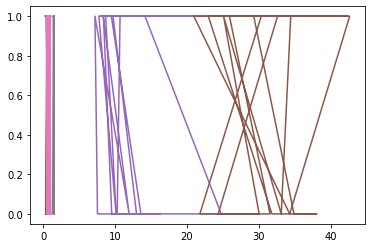

In [76]:
for m in metrics:
    print(m)
    
    plt.plot(cur_df[m].values.reshape(-1, 1), cur_df['target'].values.reshape(-1, 1), label='m')

In [ ]:
print()

,sent_cos,mean_cos,sent_l2,mean_l2,sent_l2_norm,mean_l2_norm
0.00,"{0.0: 0.5352112676056338, 0.01: 0.535211267605...","{0.0: 0.5352112676056338, 0.01: 0.535211267605...","{0.0: 0.5352112676056338, 0.01: 0.535211267605...","{0.0: 0.5352112676056338, 0.01: 0.535211267605...","{0.0: 0.5352112676056338, 0.01: 0.535211267605...","{0.0: 0.5352112676056338, 0.01: 0.535211267605..."
0.01,"{0.01: 0.5352112676056338, 0.02: 0.53521126760...","{0.01: 0.5352112676056338, 0.02: 0.53521126760...","{0.01: 0.5352112676056338, 0.02: 0.53521126760...","{0.01: 0.5352112676056338, 0.02: 0.53521126760...","{0.01: 0.5352112676056338, 0.02: 0.53521126760...","{0.01: 0.5352112676056338, 0.02: 0.53521126760..."
0.02,"{0.02: 0.5352112676056338, 0.03: 0.53521126760...","{0.02: 0.5352112676056338, 0.03: 0.53521126760...","{0.02: 0.5352112676056338, 0.03: 0.53521126760...","{0.02: 0.5352112676056338, 0.03: 0.53521126760...","{0.02: 0.5352112676056338, 0.03: 0.53521126760...","{0.02: 0.5352112676056338, 0.03: 0.53521126760..."
0.03,"{0.03: 0.5352112676056338, 0.04: 0.53521126760...","{0.03: 0.5352112676056338, 0.04: 0.53521126760...","{0.03: 0.5352112676056338, 0.04: 0.53521126760...","{0.03: 0.5352112676056338, 0.04: 0.53521126760...","{0.03: 0.5352112676056338, 0.04: 0.53521126760...","{0.03: 0.5352112676056338, 0.04: 0.53521126760..."
0.04,"{0.04: 0.5352112676056338, 0.05: 0.53521126760...","{0.04: 0.5352112676056338, 0.05: 0.53521126760...","{0.04: 0.5352112676056338, 0.05: 0.53521126760...","{0.04: 0.5352112676056338, 0.05: 0.53521126760...","{0.04: 0.5352112676056338, 0.05: 0.53521126760...","{0.04: 0.5352112676056338, 0.05: 0.53521126760..."
...,...,...,...,...,...,...
0.96,"{0.96: 0.22535211267605634, 0.97: 0.2253521126...","{0.96: 0.22535211267605634, 0.97: 0.2183098591...","{0.96: 0.22535211267605634, 0.97: 0.2253521126...","{0.96: 0.22535211267605634, 0.97: 0.2183098591...","{0.96: 0.22535211267605634, 0.97: 0.2253521126...","{0.96: 0.22535211267605634, 0.97: 0.2183098591..."
0.97,"{0.97: 0.22535211267605634, 0.98: 0.2183098591...","{0.97: 0.21830985915492956, 0.98: 0.2183098591...","{0.97: 0.22535211267605634, 0.98: 0.2183098591...","{0.97: 0.21830985915492956, 0.98: 0.2183098591...","{0.97: 0.22535211267605634, 0.98: 0.2183098591...","{0.97: 0.21830985915492956, 0.98: 0.2183098591..."
0.98,"{0.98: 0.22535211267605634, 0.99: 0.2253521126...","{0.98: 0.22535211267605634, 0.99: 0.2253521126...","{0.98: 0.22535211267605634, 0.99: 0.2253521126...","{0.98: 0.22535211267605634, 0.99: 0.2253521126...","{0.98: 0.22535211267605634, 0.99: 0.2253521126...","{0.98: 0.22535211267605634, 0.99: 0.2253521126..."
0.99,"{0.99: 0.22535211267605634, 1.0: 0.22535211267...","{0.99: 0.22535211267605634, 1.0: 0.22535211267...","{0.99: 0.22535211267605634, 1.0: 0.22535211267...","{0.99: 0.22535211267605634, 1.0: 0.22535211267...","{0.99: 0.22535211267605634, 1.0: 0.22535211267...","{0.99: 0.22535211267605634, 1.0: 0.22535211267..."


In [42]:
raw_df = pd.read_csv('test_data.csv')

In [44]:
raw_df.join(tmp_df, on=['sent', ta], how='inner')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [39]:
tmp_df.groupby('target').count()

,sent,yhat,yhat1,yhat2,mean,yhat3,yhat4,answer
target,,,,,,,,
-1,34,34,34,34,34,34,34,34
0,37,37,37,37,37,37,37,37
1,79,79,79,79,79,79,79,79


In [27]:
tmp_df['answer'] = 1 * (tmp_df[best_type] >= best_x_y[1]) -1 * (tmp_df[best_type] < best_x_y[0])

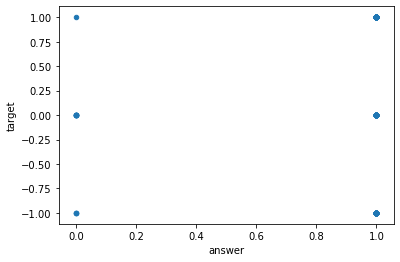

In [35]:
tmp_df.plot(kind='scatter', x='answer', y='target')

In [22]:
best

0.5666666666666667

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(df['target'], df['yhat1'])

In [ ]:
process_sentence('во второй мировой войне победила Германия', model, modelfile)

In [ ]:
sent = 'во второй мировой войне победила Германия'
#queries, pages = get_relevant_pages(get_english_translation(sent), 6)
queries, pages = get_relevant_pages(sent, 4)

In [ ]:
paragraphs = get_paragraphs(pages, queries, sent)

In [ ]:
paragraphs = get_paragraphs(pages, queries, sent)

In [ ]:
model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
#model_url = 'http://vectors.nlpl.eu/repository/20/183.zip'
#wget.download(model_url)

model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [ ]:
queries, sent_vectors = get_vectors_for_phrase(sent, model)

In [ ]:
sent_vectors.shape

In [ ]:
queries

In [ ]:
par_vectors = []
modelfile='udpipe_syntagrus.model'
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
#if not os.path.isfile(modelfile):
#    print('UDPipe model not found. Downloading...', file=sys.stderr)
#    wget.download(udpipe_model_url)
model_tag = Model.load(modelfile)
for par in tqdm(paragraphs):
    words = tag_ud(par, model_tag)
    vectors = np.array([model.get_vector(word) for word in words if word in model])
    total_vector = np.mean(vectors, axis=0)
    par_vectors.append(total_vector)
pvs = np.vstack([pv for pv in par_vectors if isinstance(pv, np.ndarray)])

In [ ]:
dist = cosine_similarity(sent_vectors, pvs)

In [ ]:
dist

In [ ]:
queries

In [ ]:
np.max(dist, axis=1)[-1], np.mean(np.max(dist, axis=1))

In [ ]:
np.argmax(dist, axis=1)

In [ ]:
for i, idx in enumerate(np.argmax(dist, axis=1)):
    print(np.max(dist, axis=1)[i])
    print(queries[i])
    print(paragraphs[idx])
    print('\n'+'='*10)

In [ ]:
df = pd.read_csv('test_data.csv')

In [ ]:
df[:150].groupby('target').count()

In [ ]:
for x in df:
    print(x)

In [ ]:

import pandas as pd
with open('train.json') as json_file:
    data = [json.loads(k) for k in json_file.read().split('\n')[:-1]]
df = pd.DataFrame(data)
print(df.groupby(['verifiable', 'label']).count())
tmp_df = df.loc[:1000, :].copy()
tmp_df['target'] = (
    (tmp_df['verifiable'] == 'VERIFIABLE')
    * tmp_df['label'].apply(lambda x: 1 if x == 'SUPPORTS' else -1)
)
tmp_df['sent'] = tmp_df['claim'].apply(lambda x: get_russian_translation(x))

In [ ]:
tmp_df[['claim', 'sent', 'target']].to_csv('test_data.csv', index=None)

In [ ]:
tmp_df.groupby(['target']).count()

In [ ]:
! conda uninstall googletrans

In [ ]:
! pip uninstall googletrans
! git clone https://github.com/BoseCorp/py-googletrans.git
! cd ./py-googletrans
! python setup.py install

In [ ]:
df.groupby(['verifiable', 'label']).count()

In [ ]:
words = tag_ud(sent)

In [ ]:
sent = ' '.join(words)
vectors = np.array([model.get_vector(word) for word in words if word in model])
total_vector = np.mean(vectors, axis=0)
total_vector

In [ ]:
import wget

udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
text_url = 'https://rusvectores.org/static/henry_sobolya.txt'

modelfile = wget.download(udpipe_url)
textfile = wget.download(text_url)

In [ ]:

model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [ ]:
process(process_pipeline, 'факт (лат. factum) — термин, в широком смысле может выступать как синоним истины')

In [ ]:
words = ['день_NOUN', 'ночь_NOUN', 'человек_NOUN', 'семантика_NOUN', 'студент_NOUN', 'студент_ADJ']

In [ ]:
for word in words:
    # есть ли слово в модели? Может быть, и нет
    if word in model:
        print(word)
        # выдаем 10 ближайших соседей слова:
        for i in model.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
            print(i[0], i[1])
        print('\n')
    else:
        # Увы!
        print(word + ' is not present in the model')

In [ ]:
print(model.similarity('человек_NOUN', 'обезьяна_NOUN'))

In [ ]:
print(model.doesnt_match('яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN'.split()))

In [ ]:
print(model.most_similar(positive=['пицца_NOUN', 'россия_NOUN'], negative=['италия_NOUN'])[0][0])

In [ ]:
model.get_vector('человек_NOUN').shape

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
def get_phrase_vector(model, sent):
    words = sent.split()
    return np.mean(np.array([model.get_vector(word) for word in words]), axis=0).reshape(1,-1)

In [ ]:
cosine_similarity(
    get_phrase_vector(model, 'яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN'),
    get_phrase_vector(model, 'яблоко_NOUN груша_NOUN виноград_NOUN банан_NOUN лимон_NOUN картофель_NOUN')
)[0,0]

In [ ]:
print(model.similarity('яблоко_NOUN', 'яблоко_NOUN'))

In [ ]:
get_phrase_vector(model, text)

In [ ]:
text = 'факт (лат. factum) — термин, в широком смысле может выступать как синоним истины'

In [ ]:
tag_ud(text=text, modelfile=modelfile)